In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nltk
!pip install bert-tensorflow
!pip install transformers
!pip install seaborn
!pip install -U sentence-transformers
!pip install pytorch-pretrained-bert
import nltk
nltk.download('punkt')
nltk.download('stopwords')


In [ ]:
# Insert code here.
import pandas as pd
import numpy as np
import random
import re
import time
import datetime
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, neighbors
from sklearn.preprocessing import LabelEncoder

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
sent_encoder = SentenceTransformer('bert-base-nli-mean-tokens')


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")  # identify and specify the GPU as the device

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/data/2020_processed_train/en.pickle'
MODEL_NAME = '/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/models/task1_model_by_epoch/bert-base-en-task1-epoch-'

In [ ]:
# Load the pickle file
with open(DATASET_PATH,'rb') as f:
    data = pickle.load(f)

In [ ]:
# create a dataframe using pickle file
df = pd.DataFrame.from_dict(data)
# df = pd.read_csv(DATASET_PATH)

In [ ]:
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

%load_ext google.colab.data_table
df.sample(10)

Number of training sentences: 3,708

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,tweet_id,task_1,task_2,hasoc_id,full_tweet,tweet_raw_text,hashtags,smiley,emoji,url,mentions,numerals,reserved_word,emotext,segmented_hash
3439,1126915725355098112,HOF,OFFN,hasoc_2020_en_4923,RT @NoyeluE: When a girl suddenly stop singing...,: When a girl suddenly stop singing while she'...,[],[],[],[],[@NoyeluE],[],[RT],[],[]
1067,1130255595079180290,NOT,NONE,hasoc_2020_en_233,RT @GFFN: Kylian Mbappé at 20:\n- 1 x World Cu...,: Kylian Mbapp at :- x World Cup- x U19 Euros-...,[],[],[],[],[@GFFN],"[ 20, 1, 1, 3, 1, 1, 1, 1]",[RT],[],[]
2468,1123657162172059649,NOT,NONE,hasoc_2020_en_88,@WB_Baskerville Excellent point. \n\nAbove: ti...,Excellent point. Above: title page of disserta...,[],[],[],[https://t.co/3DHdQHQKka],[@WB_Baskerville],[],[],[],[]
1070,1123799235852414979,HOF,PRFN,hasoc_2020_en_2987,Ah shit mtvs running a little late,Ah shit mtvs running a little late,[],[],[],[],[],[],[],[],[]
1156,1130032806258593792,NOT,NONE,hasoc_2020_en_4835,RT @alamgirizvi: I think it's our responsibili...,: I think it's our responsibility to tell ever...,[],[],"[⛩, 📿, 🕉, 👌]",[],[@alamgirizvi],[],[RT],"[shinto shrine, prayer beads, om, OK hand]",[]
326,1126912978077540353,NOT,NONE,hasoc_2020_en_4603,RT @AphraBrandreth: You don’t need an excuse t...,: You dont need an excuse to but cakes and fac...,[#CelebrateChessington],[],[],[https://t.co/uV0NfXFDLz],[@AphraBrandreth],[],[RT],[],[celebrate chessington]
3199,1123498416183631872,NOT,NONE,hasoc_2020_en_5105,"I don’t want to say it, but the fact that we c...","I dont want to say it, but the fact that we co...",[],[],[],[https://t.co/hbffui8Fm1],[],[],[],[],[]
1933,1126928568305348608,NOT,NONE,hasoc_2020_en_1884,RT @stfuIol: over 7 billion people in this wor...,: over billion people in this world and you th...,[],[],[],[],[@stfuIol],[ 7],[RT],[],[]
836,1127022029985595392,NOT,NONE,hasoc_2020_en_2158,"you put the ""utu"" in OUR ""future""😉😂","you put the ""utu"" in OUR ""future""",[],[],"[😉, 😂]",[],[],[],[],"[winking face, face with tears of joy]",[]
203,1130129581434908674,HOF,OFFN,hasoc_2020_en_3890,RT @CrypticNoOne: Who's the dumbass that drop ...,: Who's the dumbass that drop kicked Arnold Sc...,[],[],[],[https://t.co/TrEQeTiHi6],[@CrypticNoOne],[],[RT],[],[]


In [ ]:
# convert labels (categorical values) into numbers
LE = LabelEncoder()

df['task_1'] = LE.fit_transform(df['task_1'])
task1_params = dict(zip(LE.classes_, LE.transform(LE.classes_)))
print(task1_params)

df['task_2'] = LE.fit_transform(df['task_2'])
task2_params = dict(zip(LE.classes_, LE.transform(LE.classes_)))
print(task2_params)

{'HOF': 0, 'NOT': 1}
{'HATE': 0, 'NONE': 1, 'OFFN': 2, 'PRFN': 3}


In [ ]:
def count_words(text):
    return len(text.split())

In [ ]:
df.tweet_raw_text.apply(count_words).max()

31

In [ ]:
MAX_LENGTH = 40
posts = df.tweet_raw_text.values

# store binary categories for each text
categories = df['task_1'].values

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # 'encode_plus' will:
    #   (1) Tokenize the sentence. Split the sentence into tokens.
    #   (2) Prepend the [CLS] token to the start.
    #   (3) Append the [SEP] token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to 'max_length'
    #   (6) Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                           # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,        # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Original: ', posts[0])
print('Token IDs:', input_ids[0])

Original:  hate wen females hit ah nigga with tht bro , Im tryna make u my la sweety , fuck ah bro
Token IDs: tensor([  101,  5223, 19181,  3801,  2718,  6289,  9152, 23033,  2007, 16215,
         2102, 22953,  1010, 10047,  3046,  2532,  2191,  1057,  2026,  2474,
         4086,  2100,  1010,  6616,  6289, 22953,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.80 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


2,966 training samples
  742 validation samples


In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [ ]:
# Load BertForSequenceClassification,
# the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)



if torch.cuda.is_available():    
  # Tell pytorch to run this model on the GPU.
  model.cuda()
# If not...
else:
    print('No GPU available, using the CPU instead.')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# import torch.nn as nn
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     model = nn.DataParallel(model)

# model.to(device)


We can browse all of the model’s parameters by name here.

In the below cell, I’ve printed out the names and dimensions of the weights for:
1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.

In [ ]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"

optimizer = AdamW(model.parameters(),
                lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )

# The epsilon parameter eps = 1e-8 is “a very small number to prevent any division by zero in the implementation”

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
# Helper function for formatting elapsed times as hh:mm:ss

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [ ]:
seed_val = 42
torch.cuda.empty_cache()
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        """  # start - commented by anurag
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        """  # end - commented by anurag

        # start - added by anurag
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        # print(f"loss: {loss.item()}")
        # print(f"logits: {output.logits}")
        # end - added by anurag

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    torch.save(model, MODEL_NAME+str(epoch_i))
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            """  # start - commented by anurag
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            """  # end - commented by anurag

            # start - added by anurag
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            # print(f"loss: {loss}")
            # print(f"logits: {logits}")
            # end - added by anurag

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of     93.    Elapsed: 0:00:09.
  Batch    80  of     93.    Elapsed: 0:00:18.

  Average training loss: 0.39
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.28
  Validation took: 0:00:10

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     93.    Elapsed: 0:00:09.
  Batch    80  of     93.    Elapsed: 0:00:19.

  Average training loss: 0.22
  Training epcoh took: 0:00:22

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.29
  Validation took: 0:00:21

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     93.    Elapsed: 0:00:10.
  Batch    80  of     93.    Elapsed: 0:00:20.

  Average training loss: 0.15
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.32
  Validation took: 0:00:09

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     93.    Elapsed: 0:00:10.
  Batch    80  of     93.    Elapsed: 0:

Summary of the training process

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.39,0.28,0.90,0:00:21,0:00:10
2,0.22,0.29,0.89,0:00:22,0:00:21
3,0.15,0.32,0.89,0:00:23,0:00:09
4,0.11,0.33,0.90,0:00:24,0:00:09


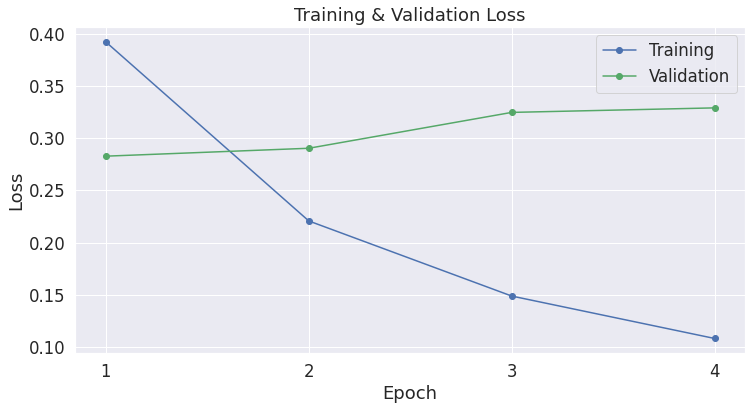

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

The training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it’s over-fitting on the training data

**Performance On Test Set**

In [ ]:
TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/data/2020_processed_test/en_test.pickle'

with open(TEST_PATH,'rb') as f:
    data_test = pickle.load(f)

df_test = pd.DataFrame.from_dict(data_test)

# Create sentence and label lists
posts = df_test.tweet_raw_text.values

categories = []

for i in df_test.task_1:
    categories.append(task1_params[i])

Data Preparation

We’ll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                           # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,        # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

# Set the batch size.  
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('\nDONE')


Predicting labels for 814 test sentences...
    DONE.


In [ ]:
print(predictions[0],true_labels[0])

[[-2.4018703   2.2060192 ]
 [-2.3457365   2.3349802 ]
 [-2.297114    2.061532  ]
 [ 2.5259047  -2.2720265 ]
 [ 2.4577847  -2.1060038 ]
 [-1.6005025   1.4974406 ]
 [ 2.5584817  -2.2886329 ]
 [ 2.646024   -2.2902195 ]
 [-0.6533378   0.8363467 ]
 [ 2.3279676  -2.1756597 ]
 [ 2.400221   -2.1513567 ]
 [ 2.5979981  -2.2410073 ]
 [ 2.311139   -2.0655768 ]
 [-2.3410292   2.1960187 ]
 [ 0.7221781  -0.21297485]
 [ 2.3980522  -1.966161  ]] [1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0]


In [ ]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.780


In [ ]:
accurate = 0
for (i,j) in zip(flat_predictions, flat_true_labels):
    if i==j:
        accurate += 1
accurate/len(flat_predictions)

0.8894348894348895

In [ ]:
from sklearn.metrics import f1_score
f1_score(flat_true_labels, flat_predictions, average='macro')

0.8894182002608317

##Method 1 to save and load model

In [ ]:
import os

output_dir = '/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/models/model_plus_tokenizer_task1/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/models/model_plus_tokenizer_task1/


('/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/models/model_plus_tokenizer_task1/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/models/model_plus_tokenizer_task1/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/models/model_plus_tokenizer_task1/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/models/model_plus_tokenizer_task1/added_tokens.json')

In [ ]:
def classify_sentence(sentence):

    input_id_sentence = []
    attention_mask_sentence = []

    model = BertForSequenceClassification.from_pretrained(output_dir)

    print(f"\nThe model can predict {model.num_labels} different classes\n")

    tokenizer = BertTokenizer.from_pretrained(output_dir)

    encoded_dict = tokenizer.encode_plus(
                sentence,                      # Sentence to encode.
                add_special_tokens = True,     # Add '[CLS]' and '[SEP]'
                max_length = MAX_LENGTH,       # Pad & truncate all sentences.
                pad_to_max_length = True,
                return_attention_mask = True,  # Construct attn. masks.
                return_tensors = 'pt',         # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.    
    input_id_sentence.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_mask_sentence.append(encoded_dict['attention_mask'])
    
    input_id_sentence = torch.cat(input_id_sentence, dim=0)
    attention_mask_sentence = torch.cat(attention_mask_sentence, dim=0)

    with torch.no_grad():
        outputs = model(input_id_sentence, token_type_ids=None, attention_mask=attention_mask_sentence)

    logits = outputs[0]

    print("\n The normalized probability for each class is")
    print(logits.softmax(dim=-1).tolist())
    pred_class_prob = logits.softmax(dim=-1).tolist()

    pred_label_from_prob = np.argmax(pred_class_prob)
    print(f"\nThe predicted class is: {pred_label_from_prob}")

    return pred_label_from_prob

In [ ]:
# Example #1
text = """
You are bad
"""
print(classify_sentence(text))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



The model can predict 2 different classes



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 The normalized probability for each class is
[[0.3133687376976013, 0.6866312026977539]]

The predicted class is: 1
1


##Method 2 to save and load model

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/models/task1_model_by_epoch/model_english_epoch_'+str(epochs)
print(MODEL_PATH)

/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/models/task1_model_by_epoch/model_english_epoch_4


In [ ]:
torch.save(model, MODEL_PATH)

In [ ]:
model = torch.load(MODEL_PATH+'4')

/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/models/bert-base-en-task1-epoch-


##Method 3 to save and load model

https://programmer.help/blogs/transformers-saves-and-loads-the-model.html

In [ ]:
import os

output_dir = '/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/models/task1_model_with_state_dict'

model_file_path = os.path.join(output_dir, "model_file.bin")
config_file_path = os.path.join(output_dir, "config_file.bin")
vocab_file_path = os.path.join(output_dir, "vocab_file.bin")

# Step 1: save a fine tuned model, configuration, and glossary

#If we have a distributed model, save only the encapsulated model
#It is wrapped in PyTorch DistributedDataParallel or DataParallel

model_to_save = model.module if hasattr(model, 'module') else model

torch.save(model_to_save.state_dict(), model_file_path)

model_to_save.config.to_json_file(config_file_path)

tokenizer.save_vocabulary(vocab_file_path)

# Step 2: reload the saved model

config = BertConfig.from_json_file(config_file_path)

model = BertForSequenceClassification(config)

state_dict = torch.load(model_file_path)

model.load_state_dict(state_dict)

model.eval()

tokenizer = BertTokenizer(vocab_file_path, do_lower_case=True)

##Method 4 to save and load model

https://huggingface.co/transformers/v1.0.0/model_doc/overview.html

In [ ]:
import os
from pytorch_pretrained_bert import WEIGHTS_NAME, CONFIG_NAME

output_dir = "/content/drive/MyDrive/Colab Notebooks/Hate-Speech-Detection/models/task1_model_saved_using_weights_name_config_name"

# Step 1: Save a model, configuration and vocabulary that you have fine-tuned

# If we have a distributed model, save only the encapsulated model
# (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
model_to_save = model.module if hasattr(model, 'module') else model

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(output_dir)

# Step 2: Re-load the saved model and vocabulary

# Example for a Bert model
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)  # Add specific options if needed

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",          # Use the 12-layer BERT model, with an uncased vocab
    num_labels = 2,               # The number of output labels--2 for binary classification
    output_attentions = False,    # Whether the model returns attentions weights
    output_hidden_states = False, # Whether the model returns all hidden-states
)